In [4]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import SGD

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [5]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [6]:
df = pd.read_csv("cleaned_data.csv", index_col=0, parse_dates=True, infer_datetime_format=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 369 entries, 1990-01-01 to 2021-08-01
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   CANLORSGPNOSTSAM                      369 non-null    float64
 1   inflation_common                      369 non-null    float64
 2   inflation_trimmed_median              369 non-null    float64
 3   inflation_weighted_median             369 non-null    float64
 4   employment_rate                       369 non-null    float64
 5   unemployment_rate                     369 non-null    float64
 6   participation_rate                    369 non-null    float64
 7   5_year_bond_benchmark                 369 non-null    float64
 8   10_year_bond_benchmark                369 non-null    float64
 9   long_term_bond_benchmark              369 non-null    float64
 10  Bank of Canada Target Overnight Rate  369 non-null    float64
 11  

In [7]:
df_input = df[['Mortgage Rate', 'inflation_common', 'unemployment_rate', '5_year_bond_benchmark', 'Bank of Canada Target Overnight Rate']]
df_input.head()

,Mortgage Rate,inflation_common,unemployment_rate,5_year_bond_benchmark,Bank of Canada Target Overnight Rate
1990-01-01,12.01,3.4,8.7,10.045000,12.04
1990-02-01,12.42,3.3,8.4,10.538182,13.00
1990-03-01,12.92,3.4,8.3,11.147692,13.13
1990-04-01,13.67,3.5,7.9,12.175000,13.52
1990-05-01,14.21,3.6,7.8,11.741538,13.80


In [8]:
scaler=MinMaxScaler()

data_scaled = scaler.fit_transform(df_input)

In [9]:
features = data_scaled
target = data_scaled[:,0]

In [10]:
TimeseriesGenerator(features, target, length=2, sampling_rate=1, batch_size=1)[0]

(array([[[0.80018165, 0.8       , 0.4137931 , 0.81990776, 0.8701107 ],
         [0.83742053, 0.76666667, 0.37931034, 0.86160646, 0.94095941]]]),
 array([0.88283379]))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123, shuffle=False)

In [12]:
X_train.shape

(295, 5)

In [13]:
X_test.shape

(74, 5)

In [25]:
win_length = 5
batch_size = 50
num_features =5

train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [26]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(128, input_shape= (win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.GRU(128, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GRU(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 5, 128)            51840     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 5, 128)            0         
                                                                 
 gru_7 (GRU)                 (None, 5, 128)            99072     
                                                                 
 dropout_4 (Dropout)         (None, 5, 128)            0         
                                                                 
 gru_8 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="min")

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer= 'SGD',
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit(train_generator, epochs=50,
                              validation_data =test_generator,
                              shuffle=False,
                              callbacks=[early_stopping])

Epoch 1/50
6/6 [==============================] - 6s 207ms/step - loss: 0.1239 - mean_absolute_error: 0.2543 - val_loss: 0.0105 - val_mean_absolute_error: 0.0986
Epoch 2/50
6/6 [==============================] - 0s 24ms/step - loss: 0.0641 - mean_absolute_error: 0.1841 - val_loss: 0.0278 - val_mean_absolute_error: 0.1647
Epoch 3/50
6/6 [==============================] - 0s 23ms/step - loss: 0.0492 - mean_absolute_error: 0.1667 - val_loss: 0.0362 - val_mean_absolute_error: 0.1884
Epoch 4/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0434 - mean_absolute_error: 0.1602 - val_loss: 0.0384 - val_mean_absolute_error: 0.1944
Epoch 5/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0404 - mean_absolute_error: 0.1588 - val_loss: 0.0385 - val_mean_absolute_error: 0.1946
Epoch 6/50
6/6 [==============================] - 0s 23ms/step - loss: 0.0370 - mean_absolute_error: 0.1505 - val_loss: 0.0368 - val_mean_absolute_error: 0.1901
Epoch 7/50
6/6 [=================

In [29]:
model.evaluate(test_generator, verbose=0)

[0.02880151756107807, 0.16803976893424988]

In [30]:
predictions=model.predict(test_generator)

In [31]:
predictions.shape[0]

69

In [33]:
X_test[:,1:][win_length:]

array([[2.33333333e-01, 1.83908046e-01, 3.83606017e-02, 1.84501845e-02],
       [2.33333333e-01, 2.87356322e-01, 2.54727133e-02, 1.84501845e-02],
       [2.00000000e-01, 3.10344828e-01, 2.09069946e-02, 1.84501845e-02],
       [2.33333333e-01, 2.98850575e-01, 3.09761722e-02, 1.84501845e-02],
       [2.33333333e-01, 2.75862069e-01, 3.64280224e-02, 1.84501845e-02],
       [2.00000000e-01, 2.18390805e-01, 3.33681051e-02, 1.84501845e-02],
       [2.00000000e-01, 1.60919540e-01, 2.32129131e-02, 1.84501845e-02],
       [1.66666667e-01, 2.41379310e-01, 2.19215988e-02, 1.84501845e-02],
       [1.66666667e-01, 2.87356322e-01, 2.48270561e-02, 1.84501845e-02],
       [1.33333333e-01, 1.60919540e-01, 2.71274844e-02, 1.84501845e-02],
       [1.33333333e-01, 1.37931034e-01, 3.01652575e-02, 1.84501845e-02],
       [1.00000000e-01, 1.49425287e-01, 4.51246294e-02, 1.84501845e-02],
       [1.00000000e-01, 1.60919540e-01, 6.55495772e-02, 1.84501845e-02],
       [6.66666667e-02, 2.41379310e-01, 6.47725193e

In [35]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(X_test[:,1:][win_length:])],axis=1)

In [36]:
rev_trans=scaler.inverse_transform(df_pred)

In [37]:
rev_trans

array([[ 5.6881315 ,  1.7       ,  6.7       ,  0.80142857,  0.5       ],
       [ 5.69385791,  1.7       ,  7.6       ,  0.649     ,  0.5       ],
       [ 5.69305007,  1.6       ,  7.8       ,  0.595     ,  0.5       ],
       [ 5.68530602,  1.7       ,  7.7       ,  0.71409091,  0.5       ],
       [ 5.67507841,  1.7       ,  7.5       ,  0.77857143,  0.5       ],
       [ 5.66924766,  1.6       ,  7.        ,  0.74238095,  0.5       ],
       [ 5.66611801,  1.6       ,  6.5       ,  0.62227273,  0.5       ],
       [ 5.66917941,  1.5       ,  7.2       ,  0.607     ,  0.5       ],
       [ 5.6697382 ,  1.5       ,  7.6       ,  0.64136364,  0.5       ],
       [ 5.66357998,  1.4       ,  6.5       ,  0.66857143,  0.5       ],
       [ 5.66131068,  1.4       ,  6.3       ,  0.7045    ,  0.5       ],
       [ 5.662529  ,  1.3       ,  6.4       ,  0.88142857,  0.5       ],
       [ 5.66364232,  1.3       ,  6.5       ,  1.123     ,  0.5       ],
       [ 5.66841291,  1.2       ,  7.2

In [38]:
df_final=df_input[predictions.shape[0]*-1:]

In [39]:
df_final.count()

Mortgage Rate                           69
inflation_common                        69
unemployment_rate                       69
5_year_bond_benchmark                   69
Bank of Canada Target Overnight Rate    69
dtype: int64

In [40]:
df_final['Mortgage_Rate_Prediction']=rev_trans[:,0]

C:\Users\Curtis lym\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

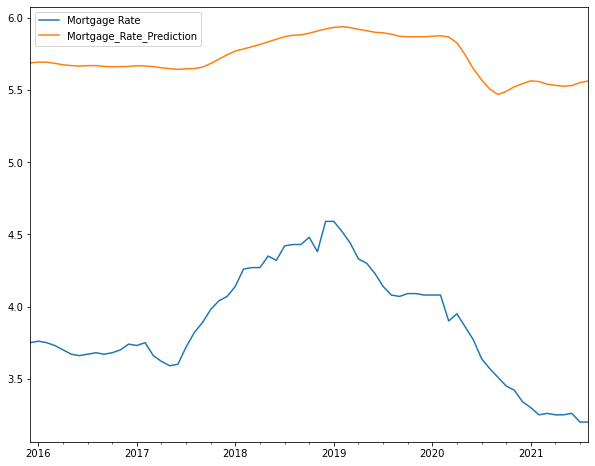

In [41]:
df_final[['Mortgage Rate', 'Mortgage_Rate_Prediction']].plot()